# IEEE Coders Week
### Final Project : Pneumonia Lungs Detection
#### By : Fahmi Jabbar (rootmawar77@gmail.com)
---
**Disclaimer**

All of the work result below is done by me, based on every resources that have been given. Please contact me if you have any good suggestion.


### Import Module

In [0]:
import tensorflow as tf
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras import backend as K

### Download Dataset

In [0]:
os.environ['KAGGLE_USERNAME'] = 'fahmijabbar'
os.environ['KAGGLE_KEY'] = '48f31e76b8b36ce3270c80c36306c84c'

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 107MB/s]
100% 2.29G/2.29G [00:29<00:00, 83.0MB/s]


### Extract Dataset

In [0]:
import zipfile as extract

zip_file = '/content/chest-xray-pneumonia.zip'
do_extract = extract.ZipFile(zip_file, 'r')
do_extract.extractall('/content/')
do_extract.close()

Deleting unused folder

In [0]:
!rm -rf /content/chest_xray/__MACOSX/
!rm -rf /content/chest_xray/chest_xray/

Switching validation & test set

In [0]:
!mv /content/chest_xray/val /content/chest_xray/vals
!mv /content/chest_xray/test /content/chest_xray/val
!mv /content/chest_xray/vals /content/chest_xray/test

Fixing imbalance dataset with deleting files

In [0]:
!find /content/chest_xray/train/PNEUMONIA -type f -print0 | sort -zR | tail -zn +1342| xargs -0 rm
!find /content/chest_xray/val/PNEUMONIA -type f -print0 | sort -zR | tail -zn +235 | xargs -0 rm

### Dataset Information

Dataset Information


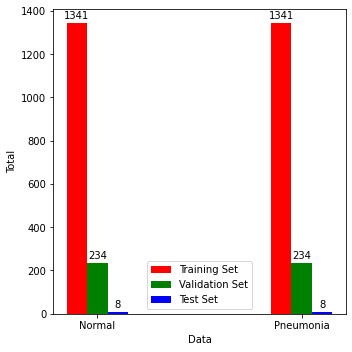

Total Dataset =  3166


In [8]:
train_n = len(os.listdir('/content/chest_xray/train/NORMAL'))
train_p = len(os.listdir('/content/chest_xray/train/PNEUMONIA'))
val_n = len(os.listdir('/content/chest_xray/val/NORMAL'))
val_p = len(os.listdir('/content/chest_xray/val/PNEUMONIA'))
test_n = len(os.listdir('/content/chest_xray/test/NORMAL'))
test_p = len(os.listdir('/content/chest_xray/test/PNEUMONIA'))

print("Dataset Information")
print("===================")
index = np.arange(2)
label = ['Normal', 'Pneumonia']
train = np.array([train_n, train_p])
val = np.array([val_n, val_p])
test = np.array([test_n, test_p])

fig, ax = plt.subplots(figsize=(5,5))
rects1 = ax.bar(index - 0.1, train, 0.1, color='r', label='Training Set', align="center")
rects2 = ax.bar(index, val, 0.1, color='g', label='Validation Set', align="center")
rects3 = ax.bar(index + 0.1, test, 0.1, color='b', label='Test Set', align="center")

def autolabel(rects, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3), 
                    textcoords="offset points",
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "center")
autolabel(rects2, "center")
autolabel(rects3, "center")
plt.xlabel('Data')
plt.ylabel('Total')
plt.xticks(index, ("Normal", "Pneumonia"))
plt.legend()
plt.tight_layout()
plt.show()

print("Total Dataset = ", train[0] + train[1] + val[0] + val[1] + test[0] + test[1])

## Data Preparation

In [0]:
train_dir = "/content/chest_xray/train/"
val_dir = "/content/chest_xray/val/"

if K.image_data_format() == 'channels_first':
    input_shape = (3, 150, 150)
else:
    input_shape = (150, 150, 3)

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

In [17]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size=(150, 150),
    class_mode='binary',
    batch_size=149,
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    directory = val_dir,
    target_size=(150, 150),
    class_mode='binary',
    batch_size=26,
    shuffle=True)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

Found 2682 images belonging to 2 classes.
Found 468 images belonging to 2 classes.


## Preview Data

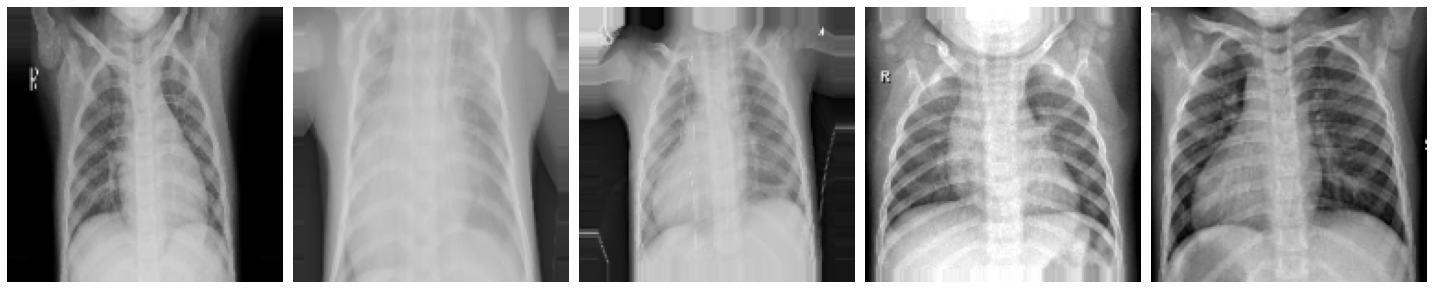

In [18]:
sample_training_image, _ = next(train_generator)

def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis("off")
  plt.tight_layout()
  plt.show()

plotImages(sample_training_image[:5])

## Model Training

In [19]:
model.summary()

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer= 'adam', 
    metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)       

In [21]:
history = model.fit(
    train_generator, 
    epochs=10, 
    steps_per_epoch= train_generator.samples / train_generator.batch_size, 
    validation_data = validation_generator, 
    verbose = 1,
    validation_steps= validation_generator.samples / validation_generator.batch_size)

Epoch 1/10
18/18 [==============================] - 53s 3s/step - loss: 0.6534 - accuracy: 0.6368 - val_loss: 0.6367 - val_accuracy: 0.6068
Epoch 2/10
18/18 [==============================] - 53s 3s/step - loss: 0.5947 - accuracy: 0.8087 - val_loss: 0.5937 - val_accuracy: 0.8419
Epoch 3/10
18/18 [==============================] - 53s 3s/step - loss: 0.5656 - accuracy: 0.8654 - val_loss: 0.5694 - val_accuracy: 0.8590
Epoch 4/10
18/18 [==============================] - 53s 3s/step - loss: 0.5601 - accuracy: 0.8788 - val_loss: 0.5637 - val_accuracy: 0.8803
Epoch 5/10
18/18 [==============================] - 53s 3s/step - loss: 0.5528 - accuracy: 0.8949 - val_loss: 0.5567 - val_accuracy: 0.8782
Epoch 6/10
18/18 [==============================] - 54s 3s/step - loss: 0.5537 - accuracy: 0.8844 - val_loss: 0.5602 - val_accuracy: 0.8889
Epoch 7/10
18/18 [==============================] - 53s 3s/step - loss: 0.5516 - accuracy: 0.8963 - val_loss: 0.5578 - val_accuracy: 0.8825
Epoch 8/10
18/18 [==

## Result & Graph

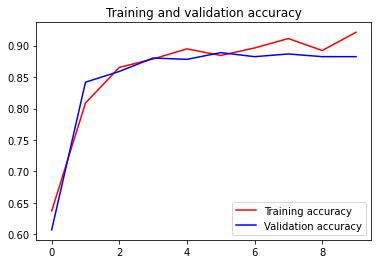

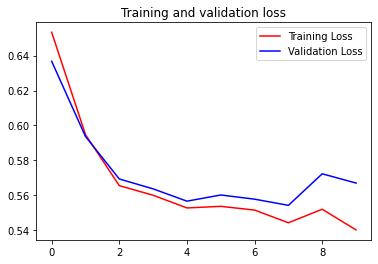

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Much more better model than before

In [23]:
path = os.listdir('/content/chest_xray/test/PNEUMONIA/')
cn = 0
cp = 0

for gambar in path:
  url = '/content/chest_xray/test/PNEUMONIA/' + gambar
  img = image.load_img(url, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  prediction = model.predict(images, batch_size=10)
  if (prediction[0][0] <= 0.5):
    print("Normal Lungs (Prediction confidence ", (1 - prediction[0][0])*100 ,"%)")
    cn += 1
  else:
    print("Pneumonia Lungs (Prediction confidence ", prediction[0][0]*100,"%)")
    cp += 1

print("\nDetecting Pneumonia")
print("=====================")
print("Total Normal (Wrong) = ", cn)
print("Total Pneumonia (Correct) = ", cp)

Pneumonia Lungs (Prediction confidence  100.0 %)
Pneumonia Lungs (Prediction confidence  100.0 %)
Pneumonia Lungs (Prediction confidence  100.0 %)
Normal Lungs (Prediction confidence  100.0 %)
Normal Lungs (Prediction confidence  99.99999918523628 %)
Normal Lungs (Prediction confidence  100.0 %)
Pneumonia Lungs (Prediction confidence  100.0 %)
Normal Lungs (Prediction confidence  100.0 %)

Detecting Pneumonia
Total Normal (Wrong) =  4
Total Pneumonia (Correct) =  4


In [24]:
path = os.listdir('/content/chest_xray/test/NORMAL/')
cn = 0
cp = 0

for gambar in path:
  url = '/content/chest_xray/test/NORMAL/' + gambar
  img = image.load_img(url, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  prediction = model.predict(images, batch_size=10)
  if (prediction[0][0] <= 0.5):
    print("Normal Lungs, Confidence ", (1 - prediction[0][0])*100 ,"%)")
    cn += 1
  else:
    print("Pneumonia Lungs, Confidence ", prediction[0][0]*100,"%)")
    cp += 1

print("\nDetecting Normal")
print("===================")
print("Total Normal (Correct) = ", cn)
print("Total Pneumonia (Wrong) = ", cp)

Normal Lungs, Confidence  100.0 %)
Normal Lungs, Confidence  100.0 %)
Normal Lungs, Confidence  100.0 %)
Normal Lungs, Confidence  100.0 %)
Normal Lungs, Confidence  100.0 %)
Normal Lungs, Confidence  100.0 %)
Normal Lungs, Confidence  100.0 %)
Normal Lungs, Confidence  100.0 %)

Detecting Normal
Total Normal (Correct) =  8
Total Pneumonia (Wrong) =  0


In [0]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [27]:
test_generator = test_datagen.flow_from_directory(
    directory='/content/chest_xray/test/',
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary')

Found 16 images belonging to 2 classes.


In [28]:
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Instructions for updating:
Please use Model.evaluate, which supports generators.

accuracy: 81.25%


Not really bad right! 

But I'm working on much more better model

## Saving Model

In [0]:
model.save('ieee-cw-fahmi.h5')

In [30]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 2.8MB/s 
     |████████████████████████████████| 144.4MB 107kB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
     |████████████████████████████████| 256kB 44.2MB/s 
     |████████████████████████████████| 921kB 43.3MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=4d7c73116b34f8f44910888041f0c699abe25f7bbc073de9e84c8bf6fddde264
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: Pygments 2.1.3
    Uninstalling Pygments-2.1.3:
      Successfully uninstalled Pygments-2.1.3
  Found existing installation: tensorflow-hub 

In [0]:
!tensorflowjs_converter --input_format=keras /content/ieee-cw-fahmi.h5 ./js

In [32]:
from google.colab import files
listfile = os.listdir('/content/js')
cc = 0

while cc < len(listfile):
  paths = '/content/js/' + listfile[cc]
  files.download(paths)
  cc += 1
else:
  print("Task Completed")

Task Completed


In [0]:
from google.colab import files
listfile = os.listdir('/content/chest_xray/test/PNEUMONIA/')
cc = 0

while cc < len(listfile):
  paths = '/content/chest_xray/test/PNEUMONIA/' + listfile[cc]
  files.download(paths)
  cc += 1
else:
  print("Task Completed")

Task Completed


In [0]:
# This cell is for my checkpoint
!mv /content/chest-xray-pneumonia.zip /tmp/chest-xray-pneumonia.zip
!rm -rf /content/*
!mv /tmp/chest-xray-pneumonia.zip /content/chest-xray-pneumonia.zip

After converting keras model to json, i will deploy the model at https://fahmij8.github.io/CodersWeek-ML/